In [1]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [3]:
model = load_model("compressor_autoencoder2.h5", compile = False)      # trained model
scaler = joblib.load("scaler2.pkl")                   # scaler from training
config = joblib.load("model_config2.pkl")             # dict with sequence_length, threshold, features

threshold = config["threshold"]
feature_columns = config["features"]

print("Loaded model, scaler, and config ✅")
print(f"Threshold: {threshold}")
print(f"features: {feature_columns}")

Loaded model, scaler, and config ✅
Threshold: 1.092542840846893
features: ['filter_dp', 'seal_gas_flow', 'seal_gas_diff_pressure', 'seal_gas_temp', 'primary_vent_flow', 'primary_vent_pressure', 'secondary_seal_gas_flow', 'separation_seal_gas_flow', 'separation_seal_gas_pressure', 'seal_gas_to_vent_diff_pressure', 'encoding']


In [ ]:
feature_columns = [
    'filter_dp',
    'seal_gas_flow',
    'seal_gas_diff_pressure',
    'seal_gas_temp',
    'primary_vent_flow',
    'primary_vent_pressure',
    'secondary_seal_gas_flow',
    'separation_seal_gas_flow',
    'separation_seal_gas_pressure',
    'seal_gas_to_vent_diff_pressure',
    'encoding'
]


In [5]:
df_E = pd.read_csv("D:\compressorA_dataset (v2).csv")

# Extract only the same features used during training
X = df_E[feature_columns].values

# Apply SAME scaler as training
X_scaled = scaler.transform(X)

c:\Users\35001745\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [6]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:(i + seq_length)])
    return np.array(sequences)
sequence_length = 10
X_test = create_sequences(X_scaled, sequence_length)

In [7]:
X_pred = model.predict(X_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [8]:
mse = np.mean(np.power(X_test - X_pred, 2), axis=(1,2))
anomalies = mse > threshold

# Align timestamps (shift for sequence length)
timestamps = df_E["timestamp"][sequence_length-1:]

prop_anomalies = np.mean(anomalies)

print(f"Threshold: {threshold:.6f}")
print(f"Total Sequences: {len(X_test)}")
print(f"Anomalous Sequences: {np.sum(anomalies)}")
print(f"Proportion anomalous: {prop_anomalies:.2%}")

Threshold: 1.092543
Total Sequences: 9991
Anomalous Sequences: 115
Proportion anomalous: 1.15%


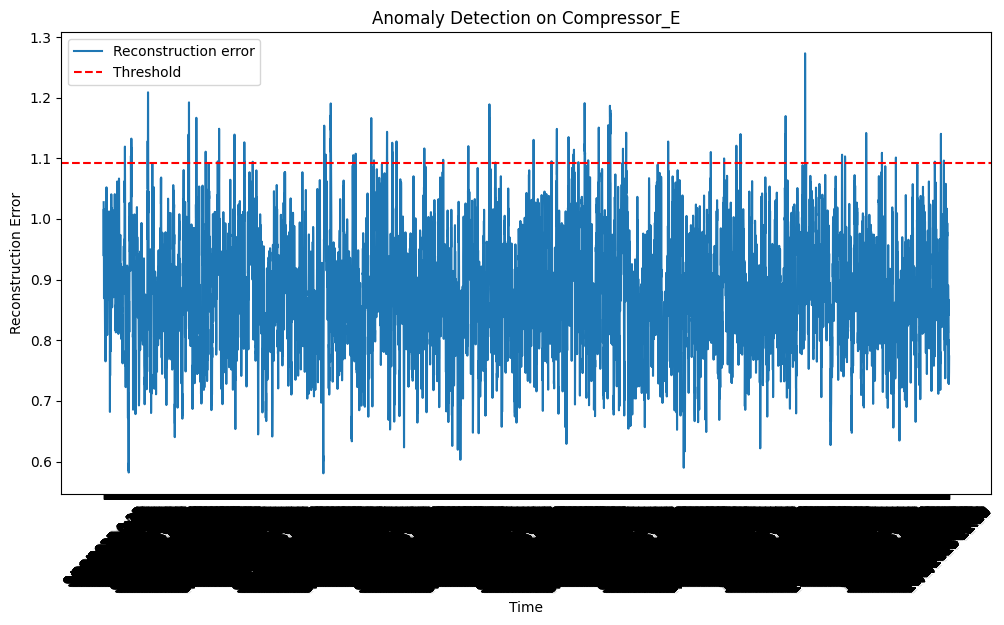

In [9]:
plt.figure(figsize=(12,6))
plt.plot(timestamps, mse, label="Reconstruction error")
plt.axhline(y=threshold, color="red", linestyle="--", label="Threshold")
plt.xticks(rotation=45)
plt.title("Anomaly Detection on Compressor_E")
plt.xlabel("Time")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

In [10]:
df_results = pd.DataFrame({
    "timestamp": timestamps,
    "reconstruction_error": mse,
    "anomaly": anomalies
})

print(df_results.head(25))

         timestamp  reconstruction_error  anomaly
9   9/26/2025 0:09              1.027636    False
10  9/26/2025 0:10              0.938974    False
11  9/26/2025 0:11              1.016158    False
12  9/26/2025 0:12              0.956889    False
13  9/26/2025 0:13              0.869764    False
14  9/26/2025 0:14              0.922884    False
15  9/26/2025 0:15              0.869124    False
16  9/26/2025 0:16              0.892242    False
17  9/26/2025 0:17              0.959172    False
18  9/26/2025 0:18              0.938003    False
19  9/26/2025 0:19              0.988020    False
20  9/26/2025 0:20              0.871070    False
21  9/26/2025 0:21              0.890928    False
22  9/26/2025 0:22              0.891008    False
23  9/26/2025 0:23              0.866903    False
24  9/26/2025 0:24              0.833899    False
25  9/26/2025 0:25              0.797914    False
26  9/26/2025 0:26              0.790842    False
27  9/26/2025 0:27              0.795917    False


In [11]:
anomalous_samples = X_test[mse > threshold]
anomalous_samples

array([[[ 4.36253747e-01, -1.63117453e+00, -1.25967300e+00, ...,
         -1.96812638e+00,  1.11916912e+00,  0.00000000e+00],
        [-1.37427082e+00,  1.26760012e+00, -6.81064399e-01, ...,
         -1.68152386e+00,  9.87392288e-01,  0.00000000e+00],
        [-1.02325075e+00,  1.92422864e+00,  1.68597077e+00, ...,
         -1.75317449e+00,  1.90983013e+00,  0.00000000e+00],
        ...,
        [-8.56978089e-01,  6.67025264e-01, -1.39117495e+00, ...,
         -1.17996945e+00,  1.71216488e+00,  0.00000000e+00],
        [-1.00477601e+00,  1.24357713e+00, -9.44068307e-01, ...,
         -1.25162008e+00,  1.96731283e-01,  0.00000000e+00],
        [ 4.82841962e-02, -7.26308409e-01,  1.86848496e-01, ...,
          2.53043158e-01,  1.64627646e+00,  0.00000000e+00]],

       [[-1.54054349e+00, -1.00657668e+00, -1.07557026e+00, ...,
          4.67995049e-01,  8.55615454e-01,  0.00000000e+00],
        [-1.35579608e+00,  1.64396037e+00, -1.28597339e+00, ...,
         -1.53822260e+00, -1.12103706e